## Network Callouts 1

- Ok I'm not sure why but getting the main visual together here is proving pretty slippery!
- I'm going to push through the "callouts", then figure out what to show for architecture
- What makes the callouts hard, but also important and powerful I think is connecting visualizations of real data moving through the network with the trigonometry.

### Attack Plan
1. Show clear sines/cosines of each input earlier in the network. Scatter plots and/or time series. Compare raw signal visually to analytical fit. I guess it might be interseting here too to do the 2d/3d plots, we'll see. 
2. Show product terms in the middle of the network. Does it matter if I find all 4? Might be nice we'll see. Again I want the analytical fit equation here. I do think at this point I should export numpy arrays and try something in manim -> this working or not could make a big difference. If it's too noisy, crazy, compare to an analytical lower frequency -> this can help me decide if it make sense to train more models and hunt for lower frequencies. One nice thing about the manim/surface approach is that I think I can show product decomposition really nicely! This step will take some time, and that's ok.
3. Show a spot or two where the network is clearly adding product terms together to cancel out some symmetry and create diagonal symmetry -> big deal! Depending on how part (2) goes, try manim surface again. Again I want analytical fit equation/approximation. 
4. Logit part is fuzzy, but I think it will be manage-able. 

In [32]:
import os
import sys
from functools import partial
from pathlib import Path

import transformer_lens
import einops
import numpy as np
import torch as t
import torch.nn.functional as F
from huggingface_hub import hf_hub_download
from jaxtyping import Float
from torch import Tensor
from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import to_numpy
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append('/home/stephen/ARENA_3.0/chapter1_transformer_interp/exercises') #Point to some Arena helpers!
import part52_grokking_and_modular_arithmetic.utils as utils

In [27]:
def fourier_approx_1d(x, num_freqs):
    """
    x: 1D real array, length N
    num_freqs: number of *unique* frequency modes to keep (by magnitude),
               counting k>0 and N-k as one mode.

    Returns:
        F_sparse: sparse 1D Fourier spectrum (complex, same shape as x)
        x_hat: real reconstruction from the sparse spectrum
    """
    N = len(x)
    F = np.fft.fft(x)

    # Unique freqs for real signals: 0..N//2 (if even) or 0..(N-1)//2 (if odd)
    if N % 2 == 0:
        max_k = N // 2
    else:
        max_k = (N - 1) // 2

    ks = np.arange(0, max_k + 1)
    mags = np.abs(F[ks])

    # Sort unique ks by magnitude (descending)
    idx_sorted = np.argsort(mags)[::-1]
    keep_ks = ks[idx_sorted[:num_freqs]]

    # Build sparse spectrum, preserving conjugate pairs
    F_sparse = np.zeros_like(F, dtype=complex)
    for k in keep_ks:
        F_sparse[k] = F[k]
        # DC and Nyquist have no distinct conjugate partner
        if k != 0 and not (N % 2 == 0 and k == N // 2):
            F_sparse[-k] = F[-k]

    x_hat = np.fft.ifft(F_sparse).real
    return F_sparse, x_hat


def spectrum_to_terms_1d(F_sparse):
    N = len(F_sparse)

    if N % 2 == 0:
        max_k = N // 2
    else:
        max_k = (N - 1) // 2

    terms = []

    for k in range(0, max_k + 1):
        c = F_sparse[k]
        if c == 0:
            continue

        if k == 0 or (N % 2 == 0 and k == N // 2):
            amp = np.abs(c) / N
        else:
            amp = 2 * np.abs(c) / N

        phase = np.angle(c)

        terms.append({
            "k": k,
            "amplitude": amp,
            "phase": phase
        })

    return terms


def generate_python_reconstructor_1d(terms, N, func_name="recon_func_1d", decimals=4):
    lines = []
    lines.append(f"def {func_name}(i):")

    if len(terms) == 0:
        lines.append("    return 0.0")
        return "\n".join(lines)

    lines.append("    return (")

    for t in terms:
        k = t["k"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        line = f"        {A} * np.cos(2*np.pi*(({k}*i)/{N}) + {phi}) +"
        lines.append(line)

    lines[-1] = lines[-1].rstrip(" +")
    lines.append("    )")

    return "\n".join(lines)


In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
t.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [3]:
p = 113

cfg = HookedTransformerConfig(
    n_layers=1,
    d_vocab=p + 1,
    d_model=128,
    d_mlp=4 * 128,
    n_heads=4,
    d_head=128 // 4,
    n_ctx=3,
    act_fn="relu",
    normalization_type=None,
    device=device,
)

model = HookedTransformer(cfg)

In [4]:
REPO_ID = "callummcdougall/grokking_full_run_data"
FILENAME = "full_run_data.pth"

local_dir = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

full_run_data = t.load(local_dir, weights_only=True)
state_dict = full_run_data["state_dicts"][400]

model = utils.load_in_state_dict(model, state_dict)

In [5]:
# Get all data and labels, and cache activations
all_data = t.tensor([(i, j, p) for i in range(p) for j in range(p)]).to(device)
labels = t.tensor([utils.target_fn(i, j) for i, j, _ in all_data]).to(device)
original_logits, cache = model.run_with_cache(all_data)

# Final position only, also remove the logits for `=`
original_logits = original_logits[:, -1, :-1]

# Get cross entropy loss
original_loss = utils.cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item():.3e}")

Original loss: 2.412e-07


In [6]:
# Helper variables
W_O = model.W_O[0]
W_K = model.W_K[0]
W_Q = model.W_Q[0]
W_V = model.W_V[0]
W_in = model.W_in[0]
W_out = model.W_out[0]
W_pos = model.W_pos
W_E = model.W_E[:-1]
final_pos_resid_initial = model.W_E[-1] + W_pos[2]
W_U = model.W_U[:, :-1]

#Functional Form
W_logit = W_out @ W_U

W_OV = W_V @ W_O
W_neur = W_E @ W_OV @ W_in

W_QK = W_Q @ W_K.transpose(-1, -2)
W_attn = final_pos_resid_initial @ W_QK @ W_E.T / (cfg.d_head**0.5)

In [7]:
m = all_data[:, 0]          # (N,)
n = all_data[:, 1]          # (N,)

t0 = F.one_hot(m, num_classes=p).float()   # (N, p)
t1 = F.one_hot(n, num_classes=p).float()   # (N, p)

# ----- 2. Compute alpha per head: α^h = σ(W_attn^h (t0 - t1)) -----
# diff: (N, p)
diff = t0 - t1

# W_attn: (n_heads, p)
# diff @ W_attn.T → (N, n_heads)
alpha = t.sigmoid(diff @ W_attn.T)         # (N, n_heads)

# For broadcasting later: (N, n_heads, 1)
alpha = alpha.unsqueeze(-1)

# ----- 3. Mix tokens per head: α^h t0 + (1-α^h) t1 -----
# Expand t0, t1 to (N, 1, p) to broadcast across heads
t0_exp = t0.unsqueeze(1)                   # (N, 1, p)
t1_exp = t1.unsqueeze(1)                   # (N, 1, p)

# token_mix: (N, n_heads, p)
token_mix = alpha * t0_exp + (1.0 - alpha) * t1_exp

# ----- 4. Map token_mix through W_neur -----
# W_neur: (n_heads, p, d_mlp)
# We want: (N, n_heads, d_mlp)
#
# Using einsum:
#  'nhp, hpd -> nhd'
neur_acts = t.einsum("nhp,hpd->nhd", token_mix, W_neur)  # (N, n_heads, d_mlp)

# Sum over heads: (N, d_mlp)
pre_mlp = neur_acts.sum(dim=1)

# ----- 5. ReLU, then logit projection -----
hidden = F.relu(pre_mlp)                  # (N, d_mlp)
logits = hidden @ W_logit                # (N, p)

In [8]:
for k in cache:
    print(k, cache[k].shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


1. Show clear sines/cosines of each input earlier in the network. Scatter plots and/or time series. Compare raw signal visually to analytical fit. I guess it might be interseting here too to do the 2d/3d plots, we'll see. 

Let me double check that hook embed won't work. 

In [16]:
# mr = einops.rearrange(cache['hook_embed'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

# fig=plt.figure(0, (12,12))
# for i in range(12):
#     for j in range(12):
#         fig.add_subplot(12,12,12*i+j+1)
#         plt.scatter(mr[0, :, 1, i], mr[0, :, 1, j], c=range(113), s=1)
#         plt.axis('off')

# Yeah, no go, that's ok

In [17]:
W_neur.shape

torch.Size([4, 113, 512])

In [18]:
m=W_neur[1].detach().cpu().numpy()

In [19]:
m.shape

(113, 512)

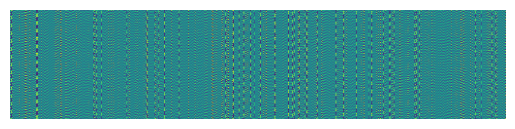

In [23]:
plt.imshow(m); plt.axis('off')
plt.savefig('/home/stephen/grokking/nov_25_1/w_neur_1.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_67234/1813589760.py:3: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (12,12))


<Figure size 640x480 with 0 Axes>

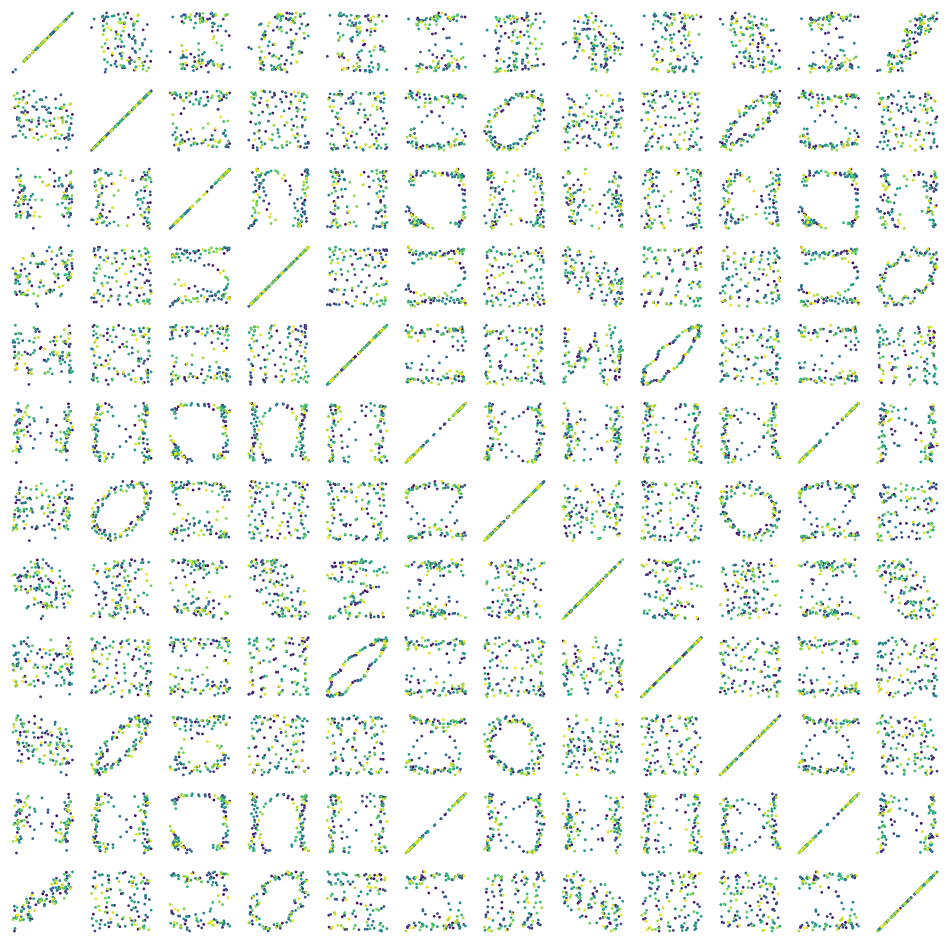

In [25]:
for fig_count in range(8): 
    plt.clf()
    fig=plt.figure(0, (12,12))
    for i in range(12):
        for j in range(12):
            fig.add_subplot(12,12,12*i+j+1)
            plt.scatter(m[:,i+12*fig_count], m[:, j+12*fig_count], c=range(113), s=1)
            plt.axis('off')
    plt.savefig('/home/stephen/grokking/nov_25_1/w_neur_scatter_'+str(fig_count)+'.png', dpi=300, bbox_inches='tight')

In [28]:
neuron_idx=2
sig=W_neur[1][:,neuron_idx].detach().cpu().numpy()

F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
terms_1d = spectrum_to_terms_1d(F_sparse)
code_1d = generate_python_reconstructor_1d(terms_1d, N=p)

In [29]:
print(code_1d)

def recon_func_1d(i):
    return (
        1.4386 * np.cos(2*np.pi*((42*i)/113) + -2.0755)
    )


In [33]:
head_index=1
res=[]
for neuron_idx in range(512):
    sig=W_neur[head_index][:,neuron_idx].detach().cpu().numpy()
    
    F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
    terms_1d = spectrum_to_terms_1d(F_sparse)
    terms_1d[0]['neuron_idx']=neuron_idx
    terms_1d[0]['err']=np.linalg.norm(sig-x_hat)/np.linalg.norm(sig)
    res.append(terms_1d[0])
df=pd.DataFrame(res)

In [41]:
df_k14 = df[df["k"] == 14]
df_k14.iloc[df_k14['err'].argsort()][:10]

,k,amplitude,phase,neuron_idx,err
241,14,1.943125,-2.843020,241,0.179858
501,14,1.668353,-2.957681,501,0.203160
222,14,1.768401,2.670051,222,0.218978
291,14,1.947914,-3.038899,291,0.227148
317,14,1.724446,0.687975,317,0.229569
480,14,1.758056,-1.857404,480,0.230142
248,14,1.944216,2.914293,248,0.230302
486,14,1.265198,-1.846968,486,0.230346
293,14,1.775200,-1.802208,293,0.231595
149,14,1.341949,0.672559,149,0.233556


In [58]:
neuron_idx=317

sig=W_neur[1][:,neuron_idx].detach().cpu().numpy()
F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
terms_1d = spectrum_to_terms_1d(F_sparse)
code_1d = generate_python_reconstructor_1d(terms_1d, N=p)

In [59]:
print(code_1d)

def recon_func_1d(i):
    return (
        1.7244 * np.cos(2*np.pi*((14*i)/113) + 0.688)
    )


In [63]:
def recon_func_1d(i):
    return (
        1.7244 * np.cos(2*np.pi*((14*i)/113) + 0.688)
    )

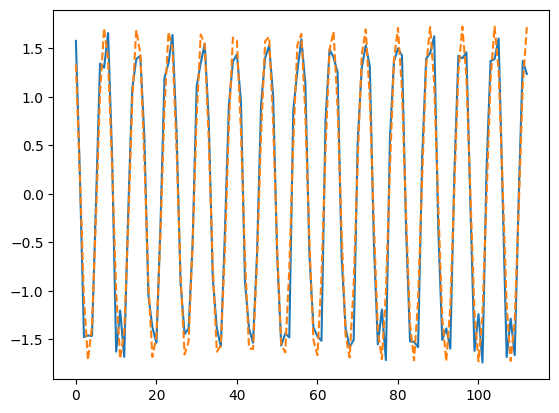

In [64]:
plt.plot(sig)
plt.plot(recon_func_1d(np.arange(p)), '--')

In [67]:
neuron_idx=293

sig=W_neur[1][:,neuron_idx].detach().cpu().numpy()
F_sparse, x_hat = fourier_approx_1d(sig, num_freqs=1)
terms_1d = spectrum_to_terms_1d(F_sparse)
code_1d = generate_python_reconstructor_1d(terms_1d, N=p)

In [68]:
print(code_1d)

def recon_func_1d(i):
    return (
        1.7752 * np.cos(2*np.pi*((14*i)/113) + -1.8022)
    )


In [69]:
def recon_func_1d(i):
    return (
        1.7752 * np.cos(2*np.pi*((14*i)/113) + -1.8022)
    )

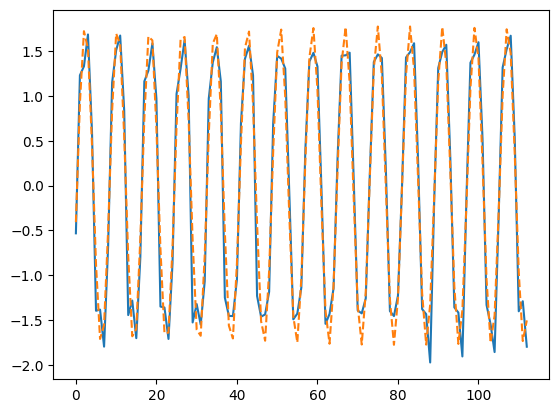

In [70]:
plt.plot(sig)
plt.plot(recon_func_1d(np.arange(p)), '--')

- Ok dope, those are nice clean sine and cosine examples.
- Hmm I guess I'll want them in manim probably? Yeah let me go ahead and wrangle a little numpy export.
- I guess I could just export the whole weights array? That's probably cleanest. 

In [73]:
np.save('/home/stephen/grokking/nov_25_1/W_nuer', W_neur[1].detach().cpu().numpy())